<a href="https://colab.research.google.com/github/suhrobm/Continuous-Mathematical-Modeling/blob/commonbranch/CMM_Inversion_Munavarov_Suhrob_J4234c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares
from ipywidgets import interact
import warnings

from google.colab import drive
drive.mount('/content/drive')

# prevents numpy scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
np.set_printoptions(suppress=False, formatter={'float_kind':'{:0.2f}'.format})
# ignoring warnings
warnings.filterwarnings(action='ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
''' reading whole dataset from the file and loading the data and save it in a working_df DataFrame
    data taken from http://people.whitman.edu/~hundledr/courses/M250F03/M250.html
'''
path = '/content/drive/MyDrive/ITMO/CMM/LynxHare.txt'
working_df = pd.read_csv(path, delim_whitespace=True, header=None)
working_df.head(10)

,0,1,2
0,1845,19.58,30.09
1,1846,19.60,45.15
2,1847,19.61,49.15
3,1848,11.99,39.52
4,1849,28.04,21.23
5,1850,58.00,8.42
6,1851,74.60,5.56
7,1852,75.09,5.08
8,1853,88.48,10.17
9,1854,61.28,19.60


In [103]:
''' here above, we can see that the columns in the working_df DataFrame are unnamed. So, we can add/name columns
    to an existing working_df DataFrame using its columns attribute.

'''
working_df.columns = ['Year', 'Hare', 'Lynx']  # naming columns respectively
working_df.head(10)

,Year,Hare,Lynx
0,1845,19.58,30.09
1,1846,19.60,45.15
2,1847,19.61,49.15
3,1848,11.99,39.52
4,1849,28.04,21.23
5,1850,58.00,8.42
6,1851,74.60,5.56
7,1852,75.09,5.08
8,1853,88.48,10.17
9,1854,61.28,19.60


In [104]:
working_df = working_df.loc[working_df['Year']>=1900]
working_df

,Year,Hare,Lynx
55,1900,12.82,7.13
56,1901,4.72,9.47
57,1902,4.73,14.86
58,1903,37.22,31.47
59,1904,69.72,60.57
60,1905,57.78,63.51
61,1906,28.68,54.70
62,1907,23.37,6.30
63,1908,21.54,3.41
64,1909,26.34,5.44


In [150]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Hare/Lynx Population Dynamics"):
    ax.plot(working_df.Year, working_df.Lynx, color="c", lw=lw, marker="o", markersize=12, label="Lynx")
    ax.plot(working_df.Year, working_df.Hare, color="y", lw=lw, marker="+", markersize=14, label="Hare")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylim(-5)
    ax.grid(True)
    ax.set_xlabel("Shortened Time Period", fontsize=14)
    ax.set_ylabel("Thousands of animals", fontsize=14)
    ax.set_xticks(working_df.Year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=12)
    return ax

<Axes: title={'center': 'Hare/Lynx Population Dynamics'}, xlabel='Shortened Time Period', ylabel='Thousands of animals'>

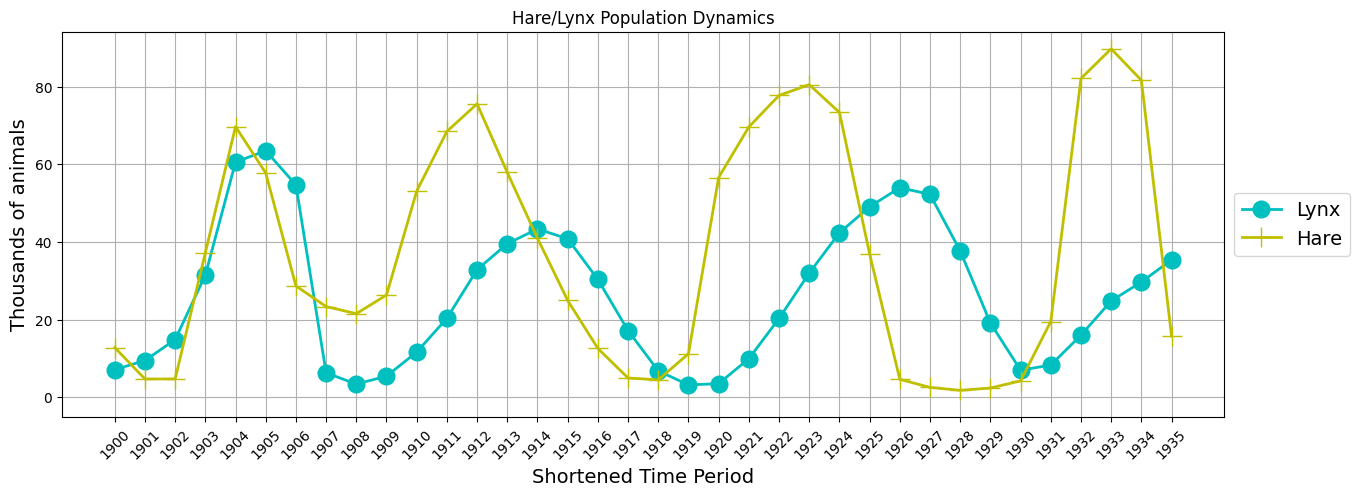

In [151]:
_ , ax = plt.subplots(figsize=(15, 5))
plot_data(ax)

In [105]:
'''
    setting previous parameters' values to the inverse_parameters variable
'''
inverse_parameters = np.array([3.2, 0.6, 50, 0.56, 1.6, 153, 20, 20])

In [106]:
# function that calculates residuals based on a given inverse_parameters
def ode_model_resid(inverse_parameters):
    return (
        working_df[["Hare", "Lynx"]] - odeint(func=derivative_inverse, y0=inverse_parameters[-2:], t=working_df.Year, args=(inverse_parameters,))
    ).values.flatten()

In [122]:
def pytensor_forward_model_matrix(inverse_parameters):
    return odeint(derivative_inverse, inverse_parameters[-2:], working_df.Year)

In [108]:
# define the right hand side of the ODE equations in the Scipy odeint signature
def derivative_inverse(X, t, inverse_parameters):
    # unpack parameters
    Hare, Lynx = X
    a, b, c, d, r, hare_k, Hare0, Lynx0 = inverse_parameters
    # equations
    dHare = r * Hare * (1 - Hare/hare_k) - a * Hare * Lynx/(c + Hare)   # model for Hare
    dLynx = b * a * Hare * Lynx/(c + Hare) - d * Lynx                   # model for Lynx
    return [dHare, dLynx]

In [109]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, inverse_parameters)
inverse_parameters = results.x  # least squares solution used to inform the priors

In [110]:
with pm.Model() as model:
    # Priors
    a = pm.TruncatedNormal("a", mu=inverse_parameters[0], sigma=0.1, lower=0, initval=inverse_parameters[0])
    b = pm.TruncatedNormal("b", mu=inverse_parameters[1], sigma=0.01, lower=0, initval=inverse_parameters[1])
    c = pm.TruncatedNormal("c", mu=inverse_parameters[2], sigma=0.1, lower=0, initval=inverse_parameters[2])
    d = pm.TruncatedNormal("d", mu=inverse_parameters[3], sigma=0.01, lower=0, initval=inverse_parameters[3])
    r = pm.TruncatedNormal("r", mu=inverse_parameters[4], sigma=1, lower=0, initval=inverse_parameters[4])
    hare_k = pm.TruncatedNormal("hare_k", mu=inverse_parameters[5], sigma=1, lower=0, initval=inverse_parameters[5])
    Hare0 = pm.TruncatedNormal("Hare0", mu=inverse_parameters[6], sigma=1, lower=0, initval=inverse_parameters[6])
    Lynx0 = pm.TruncatedNormal("Lynx0", mu=inverse_parameters[7], sigma=1, lower=0, initval=inverse_parameters[7])
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(pm.math.stack([a, b, c, d, r, hare_k, Hare0, Lynx0]))

    # Likelihood
    pm.Normal("Y_obs", ode_solution, sigma, working_df[["Hare", "Lynx"]].values)


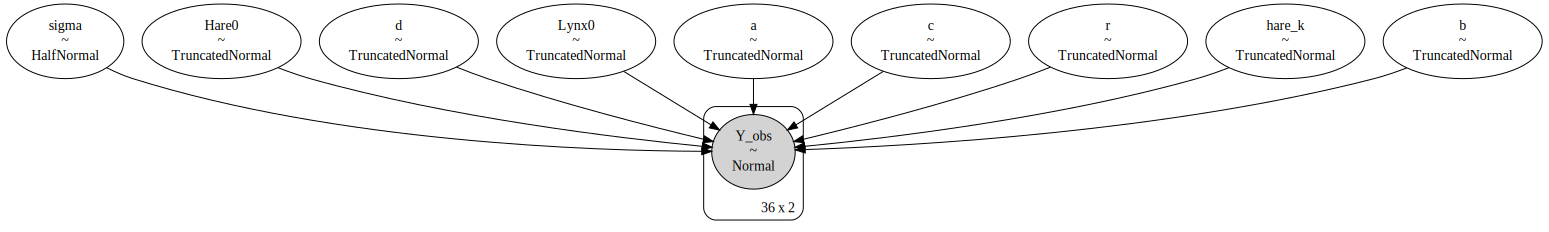

In [111]:
pm.model_to_graphviz(model)

In [112]:
# simulator function based on the signature rng, parameters, size.
def simulator_forward_model(rng, a, b, c, d, r, hare_k, Hare0, Lynx0, sigma, size=None):
    inverse_parameters = a, b, c, d, r, hare_k, Hare0, Lynx0
    mu = odeint(derivative_inverse, inverse_parameters[-2:], working_df.Year)
    return rng.normal(mu, sigma)

In [113]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    a = pm.TruncatedNormal("a", mu=inverse_parameters[0], sigma=0.1, lower=0, initval=inverse_parameters[0])
    b = pm.TruncatedNormal("b", mu=inverse_parameters[1], sigma=0.01, lower=0, initval=inverse_parameters[1])
    c = pm.TruncatedNormal("c", mu=inverse_parameters[2], sigma=0.1, lower=0, initval=inverse_parameters[2])
    d = pm.TruncatedNormal("d", mu=inverse_parameters[3], sigma=0.01, lower=0, initval=inverse_parameters[3])
    r = pm.TruncatedNormal("r", mu=inverse_parameters[4], sigma=1, lower=0, initval=inverse_parameters[4])
    hare_k = pm.TruncatedNormal("hare_k", mu=inverse_parameters[5], sigma=1, lower=0, initval=inverse_parameters[5])
    Hare0 = pm.TruncatedNormal("Hare0", mu=inverse_parameters[6], sigma=1, lower=0, initval=inverse_parameters[6])
    Lynx0 = pm.TruncatedNormal("Lynx0", mu=inverse_parameters[7], sigma=1, lower=0, initval=inverse_parameters[7])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    pm.Simulator("Y_obs", simulator_forward_model, params=(a, b, c, d, r, hare_k, Hare0, Lynx0, sigma), epsilon=10, observed=working_df[["Hare", "Lynx"]].values,)



In [114]:
sampler = "SMC epsilon=10"
draws = 2000
with model:
    trace_SMC_e10 = pm.sample_smc(draws)
trace = trace_SMC_e10
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.379,0.076,3.268,3.463,0.040,0.031,4.0,16.0,1.54
b,0.413,0.008,0.401,0.424,0.004,0.003,5.0,2.0,1.46
c,36.525,0.108,36.355,36.641,0.051,0.039,5.0,4.0,1.57
d,0.563,0.006,0.548,0.570,0.003,0.002,6.0,52.0,1.61
r,2.093,0.069,1.992,2.213,0.033,0.025,4.0,3.0,1.43
hare_k,119.893,0.843,118.409,120.778,0.374,0.282,8.0,169.0,1.45
Hare0,17.449,1.057,15.766,18.780,0.607,0.479,4.0,2.0,1.86
Lynx0,23.540,0.921,22.521,24.853,0.521,0.412,4.0,20.0,1.59
sigma,5.916,2.005,1.499,7.999,0.700,0.552,6.0,21.0,1.27


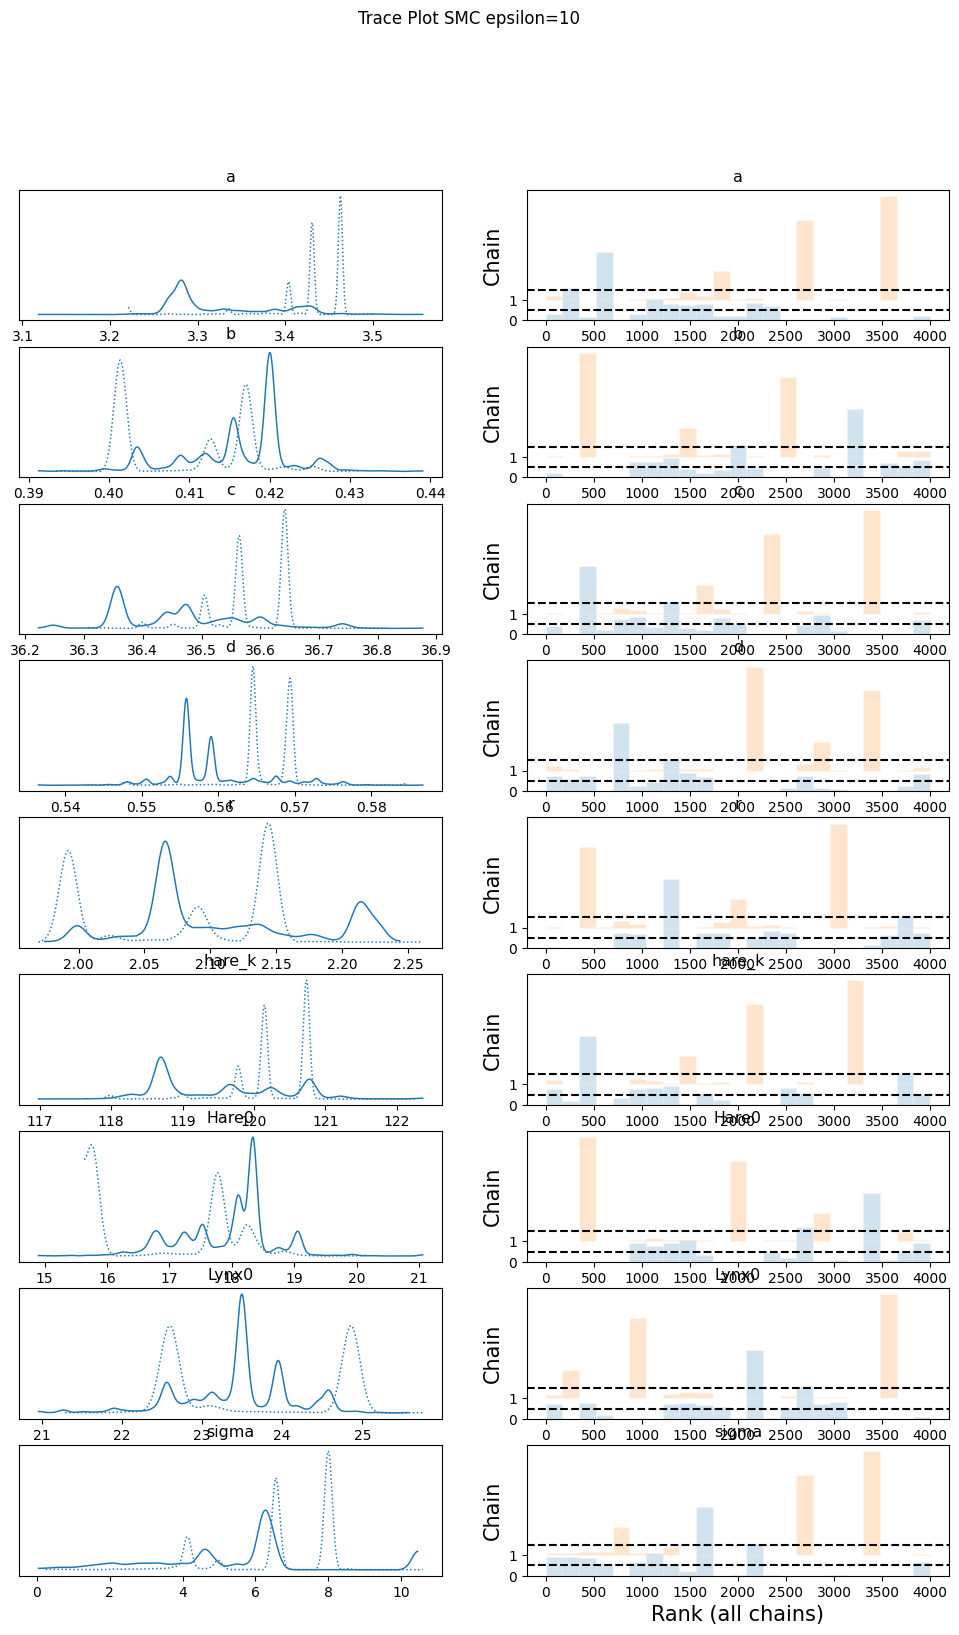

In [115]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

In [139]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=working_df.Year,
    alpha=1,
    lw=3,
    title="Hare/Lynx Population Dynamics and\nExample Model Run",
):
    ax.plot(time, x_y[:, 1], color="c", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="y", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    return ax

In [143]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["a", "b", "c", "d", "r", "hare_k", "Hare0", "Lynx0"]
    row = trace_df.iloc[row_idx, :][cols].values

    # a, b, c, d, r, hare_k, Hare0, Lynx0
    time = working_df.Year
    inverse_parameters = row
    x_y = odeint(func=derivative_inverse, y0=inverse_parameters[-2:], t=time, args=(inverse_parameters,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [146]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hare/Lynx Population Dynamics and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=12)
    ax.grid(True)

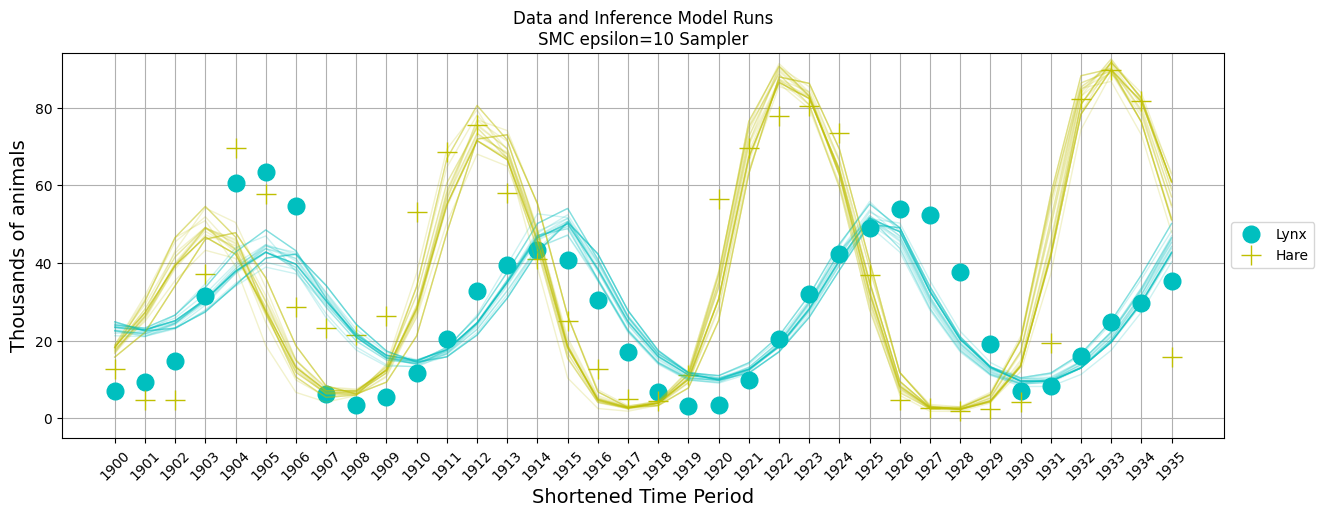

In [147]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");